# Generative Adversarial Networks (GANs) for STL Objects

This notebook attempts to recreate examples of GANs from several blogs found online. Note: all comments made with '###' are my own, and the are from the code graciously borrowed from the tutorials.

## I. Augustinus Kristiadi's GAN

This VAE was written by Augustinus Kristiadi and demonstrated at https://wiseodd.github.io/techblog/2016/09/17/gan-tensorflow/.

The exact implementation can be found at https://github.com/wiseodd/generative-models/blob/master/GAN/vanilla_gan/gan_tensorflow.py

**Cynthia:**
The above tutorial uses simple two-layer nn and we can use CNN to replace it.

## Environment Setup

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import time
import os
%matplotlib inline

np.random.seed(0)
tf.set_random_seed(0)

## Import Data

In [2]:
# import data
import env
from data.thingi10k import Thingi10k
from data import THINGI10K_INDEX
from data.stl import save_vectors_as_stl
from data.stl import plot_mesh

thingi = Thingi10k.init10()
n_samples = len(thingi)
n_samples

10

In [4]:
# some models are quite large and cause this architecture to hit a memory error
# also tensors cannot be greater than 2 GB!
# to calculate size in bytes of tensor, take size of architecture layer * vector length * 4

#n_input = 90000  # multiple of 9!! vertices come in 3! any less and you're cutting off vital info
n_input = thingi.max_length()

print('n_samples: {}'.format(n_samples))
print('n_input: {}'.format(n_input))
size_bytes = n_input * 100 * 4
print('size: {} bytes'.format(size_bytes))
size_gb = size_bytes / 1024 / 1024 / 1024
print('size: {:.2f} gb'.format(size_bytes / 1024 / 1024 / 1024))
assert size_gb < 2

n_samples: 10
n_input: 276048
size: 110419200 bytes
size: 0.10 gb


## GAN

In [16]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)


def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])


def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

In [7]:
# from tensorflow.examples.tutorials.mnist import input_data
# mnist = input_data.read_data_sets('../../MNIST_data', one_hot=True)
len(mnist)

3

In [13]:
28*28

784

In [17]:
# Discriminator Net
X = tf.placeholder(tf.float32, shape=[None, n_input]) # what's the number of features for stl, # of vertices?

D_W1 = tf.Variable(xavier_init([n_input, 128])) # used 128 for MNIST, the len of dataset?
D_b1 = tf.Variable(tf.zeros(shape=[128]))

D_W2 = tf.Variable(xavier_init([128, 1]))
D_b2 = tf.Variable(tf.zeros(shape=[1]))

theta_D = [D_W1, D_W2, D_b1, D_b2]

In [18]:
# Generator Net
Z = tf.placeholder(tf.float32, shape=[None, 100]) # inialized vector of 100 noises

G_W1 = tf.Variable(xavier_init([100, 128]))
G_b1 = tf.Variable(tf.zeros(shape=[128]))

G_W2 = tf.Variable(xavier_init([128, n_input]))
G_b2 = tf.Variable(tf.zeros(shape=[n_input]))

theta_G = [G_W1, G_W2, G_b1, G_b2]

In [19]:
def generator(z):
    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)

    return G_prob


def discriminator(x):
    D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)

    return D_prob, D_logit

In [20]:
G_sample = generator(Z)
D_real, D_logit_real = discriminator(X)
D_fake, D_logit_fake = discriminator(G_sample)

# D_loss = -tf.reduce_mean(tf.log(D_real) + tf.log(1. - D_fake))
# G_loss = -tf.reduce_mean(tf.log(D_fake))

# Alternative losses:
# -------------------
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
D_loss = D_loss_real + D_loss_fake
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))

D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)

mb_size = 128
Z_dim = 100

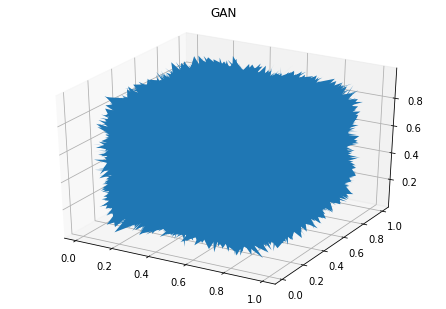

Iter: 0
Elapsed Time: 3.37 mins
D loss: 9.737
G_loss: 346.2

Iter: 10
Elapsed Time: 4.37 mins
D loss: 5.865e-06
G_loss: 788.6

Iter: 20
Elapsed Time: 5.17 mins
D loss: 5.451e-08
G_loss: 327.6

Iter: 30
Elapsed Time: 5.99 mins
D loss: 0.4022
G_loss: 169.1

Iter: 40
Elapsed Time: 6.60 mins
D loss: 4.895e-09
G_loss: 211.4



In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

if not os.path.exists('_output/'):
    os.makedirs('_output/')

i = 0
start = time.time()

for it in range(100):
    if it % 50 == 0:
        samples = sess.run(G_sample, feed_dict={Z: sample_Z(16, Z_dim)})
#         print(samples)
        x_reconstruct_vectors = samples.reshape([-1, 3, 3])
        plot_mesh(x_reconstruct_vectors, title='GAN')
    save_vectors_as_stl(x_reconstruct_vectors, 'first_gan_stl.stl')
        
#     X_mb, _ = mnist.train.next_batch(mb_size)
    thingi.batchmaker(batch_size=10, normalize=True, flat=True, pad_length=n_input, filenames=False)
    X_mb = batch
    _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_mb, Z: sample_Z(mb_size, Z_dim)})
    _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z: sample_Z(mb_size, Z_dim)})

    if it % 10 == 0:
        print('Iter: {}'.format(it))
        print('Elapsed Time: {:.2f} mins'.format((time.time() - start) / 60))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        print()

In [57]:
save_vectors_as_stl(x_reconstruct_vectors, 'first_gan_stl.stl')